# ABC Guide for XMM-Newton -- Chapter 8 (Timing Mode)

---

#### Introduction
This tutorial is based on Chapter 8 from the [The XMM-Newton ABC Guide](https://heasarc.gsfc.nasa.gov/docs/xmm/abc/ "ABC Guide") prepared by the NASA/GSFC XMM-Newton Guest Observer Facility. This notebook assumes you are using the version of pySAS found on [GitHub](https://github.com/XMMGOF/pysas) and have already configured it to work with your SAS installation (see the [README on GitHub](https://github.com/XMMGOF/pysas/blob/main/README.md)). 
#### Expected Outcome
The ability to process EPIC data in the timing mode and prepare it for analysis.
#### SAS Tasks to be Used

- `epproc`[(Documentation for epproc)](https://xmm-tools.cosmos.esa.int/external/sas/current/doc/epproc/index.html "epproc Documentation")
- `evselect`[(Documentation for evselect)](https://xmm-tools.cosmos.esa.int/external/sas/current/doc/evselect/index.html)
- `tabgtigen`[(Documentation for tabgtigen)](https://xmm-tools.cosmos.esa.int/external/sas/current/doc/tabgtigen/index.html)
- `gtibuild`[(Documentation for gtibuild)](https://xmm-tools.cosmos.esa.int/external/sas/current/doc/gtibuild/index.html)

#### Prerequisites
<div class="alert alert-block alert-info">
    <b>Note:</b> Before running this notebook, or even starting a Jupyter Lab session, HEASOFT has to be initialized. If you did not initalize HEASOFT before starting this Jupyter Lab session, or opening this notebook, please close this window and initalize HEASOFT (it is not possible to initalize HEASOFT from within a Jupyter Notebook). SAS defaults for your machine will need to be set as explained in the README on GitHub (https://github.com/XMMGOF/pysas/blob/main/README.md).
</div>

#### Useful Links

- [`pysas` Documentation](https://xmm-tools.cosmos.esa.int/external/sas/current/doc/pysas/index.html "pysas Documentation")
- [`pysas` on GitHub](https://github.com/XMMGOF/pysas)
- [Common SAS Threads](https://www.cosmos.esa.int/web/xmm-newton/sas-threads "SAS Threads")
- [Users' Guide to the XMM-Newton Science Analysis System (SAS)](https://xmm-tools.cosmos.esa.int/external/xmm_user_support/documentation/sas_usg/USG/SASUSG.html "Users' Guide")
- [The XMM-Newton ABC Guide](https://heasarc.gsfc.nasa.gov/docs/xmm/abc/ "ABC Guide")
- [XMM Newton GOF Helpdesk](https://heasarc.gsfc.nasa.gov/docs/xmm/xmm_helpdesk.html "Helpdesk") - Link to form to contact the GOF Helpdesk.

#### Caveats
This tutorial uses an observation of Cen X-3 (obsid = '0400550201').

##### Last Reviewed: _25 April 2024, for SAS v21_
##### Last Updated: _25 April 2024_
##### By: Ryan Tanner (ryan.tanner@nasa.gov)
---

In [1]:
# pySAS imports
import pysas
from pysas.wrapper import Wrapper as w

# Useful imports
import os
import subprocess

# Imports for plotting
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
plt.style.use(astropy_mpl_style)

### 8.1 : Rerun basic processing

<div class="alert alert-block alert-info">
    <b>Note:</b> Running epproc and emproc on this particular obsid will take A LONG TIME, depending on your machine. Be prepared to wait.
</div>

In [2]:
obsid = '0400550201'
odf = pysas.odfcontrol.ODFobject(obsid)
odf.basic_setup(overwrite=False,repo='heasarc',rerun=False)

obs_dir found at /home/rtanner2/xmm_data/0400550201.
odf_dir found at /home/rtanner2/xmm_data/0400550201/ODF.
work_dir found at /home/rtanner2/xmm_data/0400550201/work.
SAS_CCF = /home/rtanner2/xmm_data/0400550201/work/ccf.cif
SAS_ODF = /home/rtanner2/xmm_data/0400550201/work/1192_0400550201_SCX00000SUM.SAS
 > 2 EPIC-MOS2 event list(s) found.

    /home/rtanner2/xmm_data/0400550201/work/1192_0400550201_EMOS2_S002_TimingEvts.ds

    /home/rtanner2/xmm_data/0400550201/work/1192_0400550201_EMOS2_S002_ImagingEvts.ds

 > 1 EPIC-pn event list(s) found.

    /home/rtanner2/xmm_data/0400550201/work/1192_0400550201_EPN_S003_TimingEvts.ds



        Starting SAS session

        Data directory = /home/rtanner2/xmm_data

        
SAS_CCF = /home/rtanner2/xmm_data/0400550201/work/ccf.cif
SAS_ODF = /home/rtanner2/xmm_data/0400550201/work/1192_0400550201_SCX00000SUM.SAS
[]
 > 1 EPIC-pn event list found. Not running epproc again.

    /home/rtanner2/xmm_data/0400550201/work/1192_0400550201_EPN_S003_T

We start by reprocessing the data. The SAS task `epproc` will automatically detect if the data was taken in either imaging mode or timing mode.

We also note that for this particular observation not all instruments were used. Which instruments were active for this observation is stored in a dictionary in the `odf` object. This data is contained in the ODF summary file, `sas_odf`.

In [3]:
odf.active_instruments

{'M1': False, 'M2': True, 'R1': True, 'R2': True, 'PN': True, 'OM': False}

We see that only one of the MOS cameras was used, both RGS, the pn, but not the optical monitor. In this case we only care about the pn.

### 8.2 : Create and Display an Image

Below we define a useful function to make image plotting easier. It uses `evselect` to create a FITS image file from a FITS event list file. As a default it creates a file named "image.fits" and this file will be overwritten each time the function is called. If you want your image file to have a unique name then use the function input "image_file". For example:

```python
make_fits_image('event_list_file.fits', image_file='my_special_image.fits')
```
---
The input arguments to `evselect` to create a FITS image file are:

    table - input event list file name
    withimageset - make an image
    imageset - name of output image file
    xcolumn - event column for X axis
    ycolumn - event column for Y axis
    imagebinning - form of binning, force entire image into a given size or bin by a specified number of pixels
    ximagebinsize - output X bin sizes in pixels
    yimagebinsize - output Y bin sizes in pixels

<div class="alert alert-block alert-info">
    <b>Note:</b> The inputs for evselect are slightly different from inputs used for plotting in the Jupyter Notebook for Chapter 6, Part 1 of the ABC Guide. In that notebook the image was binned to a total number of pixels in the X and Y directions. Here the detector pixels are binned using a set bin size, in this case "1" in both the X and Y directions.
</div>

In [4]:
def make_fits_image(event_list_file, image_file='image.fits', expression=None):
    
    inargs = {}
    inargs['table']        = event_list_file
    inargs['withimageset'] = 'yes'
    inargs['imageset']     = image_file
    inargs['xcolumn']      = 'RAWX'
    inargs['ycolumn']      = 'RAWY'
    inargs['imagebinning'] = 'binSize'
    inargs['ximagebinsize']   = '1'
    inargs['yimagebinsize']   = '1'
    if expression != None:
        inargs['expression'] = expression
    
    w('evselect', inargs).run()

    hdu = fits.open(image_file)[0]
    plt.imshow(hdu.data, origin='lower', norm='log', aspect=0.2)
    plt.colorbar()
    plt.show()

We also define a function to make plotting light curves simpler. As with the function `make_fits_image` it uses `evselect` to create the light curve. It also creates a default light curve FITS file.

---
The input arguments to `evselect` to create a light curve file are:

    table - input event table
    withrateset - make a light curve
    rateset - name of output light curve file
    maketimecolumn - control to create a time column
    timecolumn - time column label
    timebinsize - time binning (seconds)
    makeratecolumn - control to create a count rate column, otherwise a count column will be created


In [5]:
def plot_light_curve(event_list_file, light_curve_file='ltcrv.fits'):
                     
    inargs = {'table': event_list_file, 
              'withrateset': 'yes', 
              'rateset': light_curve_file, 
              'maketimecolumn': 'yes', 
              'timecolumn': 'TIME', 
              'timebinsize': '50', 
              'makeratecolumn': 'yes'}

    w('evselect', inargs).run()

    ts = Table.read(light_curve_file,hdu=1)
    plt.plot(ts['TIME'],ts['RATE'])
    plt.xlabel('Time (s)')
    plt.ylabel('Count Rate (ct/s)')
    plt.show()

We need to change into the work directory to run the next SAS tasks. We also get the name and path to the event list file created in §8.1.

In [6]:
os.chdir(odf.work_dir)
pn_burst           = odf.files['PNevt_list'][0]
basic_filter_file  = 'pn_basic_filter.fits'
basic_filter_image = 'pn_basic_image.fits'
basic_filter_ltcrv = 'basic_filter_ltcrv.fits'
final_filter_image = 'final_filter_image.fits'
source_pi_file     = 'source_pi_WithBore.fits'
bkg_pi_file        = 'bkg_pi.fits'
pn_spectra_file    = 'pn_filt_source_WithBore.fits'
pn_bkg_file        = 'pn_filt_bkg.fits'

Here we plot an image of the raw data with no filters applied.

Executing: 
evselect table='/home/rtanner2/xmm_data/0400550201/work/1192_0400550201_EPN_S003_TimingEvts.ds' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='binSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0'

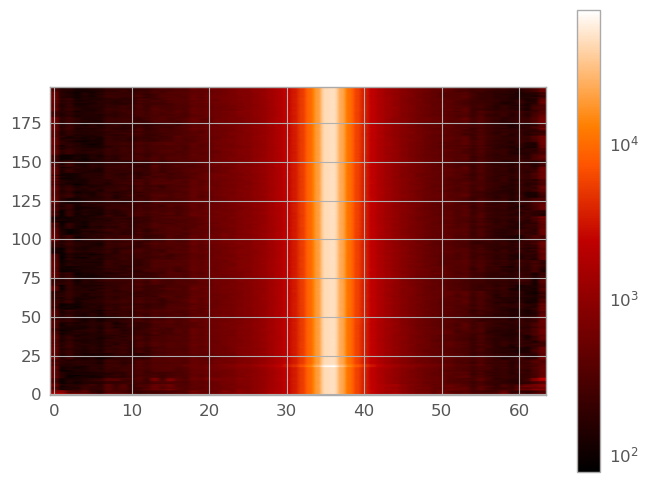

In [7]:
make_fits_image(pn_burst)

Executing: 
evselect table='/home/rtanner2/xmm_data/0400550201/work/1192_0400550201_EPN_S003_TimingEvts.ds' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0

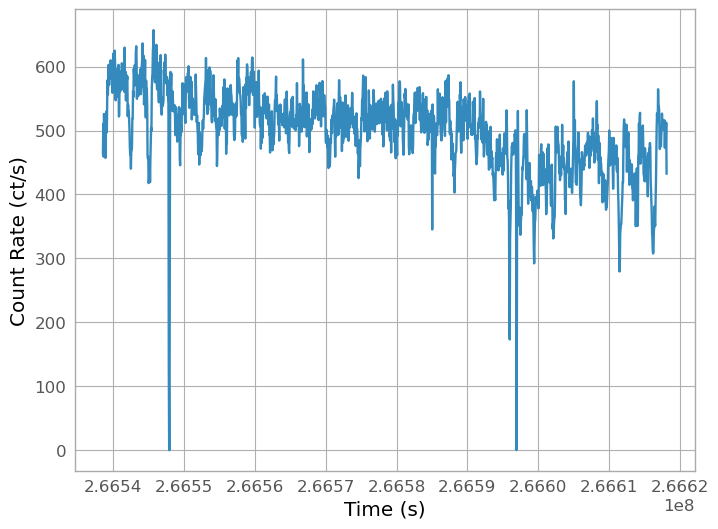

In [8]:
plot_light_curve(pn_burst)

### 8.3 : Apply Standard Filter

The filtering expression for the PN in Timing mode is:
```
(PATTERN <= 4)&&(PI in [200:15000])&&#XMMEA_EP
```
The first two expressions will select good events with PATTERN in the 0 to 4 range. The PATTERN value is similar the GRADE selection for ASCA data, and is related to the number and pattern of the CCD pixels triggered for a given event. Single pixel events have PATTERN == 0, while double pixel events have PATTERN in [1:4].

The second keyword in the expressions, PI, selects the preferred pulse height of the event; for the PN, this should be between 200 and 15000 eV. This should clean up the image significantly with most of the rest of the obvious contamination due to low pulse height events. Setting the lower PI channel limit somewhat higher (e.g., to 300 or 400 eV) will eliminate much of the Here we will use a lower limit of 400 eV. rest.

Finally, the #XMMEA_EP filter provides a canned screening set of FLAG values for the event. (The FLAG value provides a bit encoding of various event conditions, e.g., near hot pixels or outside of the field of view.) Setting FLAG == 0 in the selection expression provides the most conservative screening criteria and should always be used when serious spectral analysis is to be done on PN data.

Executing: 
evselect table='/home/rtanner2/xmm_data/0400550201/work/1192_0400550201_EPN_S003_TimingEvts.ds' keepfilteroutput='yes' withfilteredset='yes' filteredset='pn_basic_filter.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(PATTERN <= 4)&&(PI in [200:15000])&&#XMMEA_EP' writedss='no' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectra

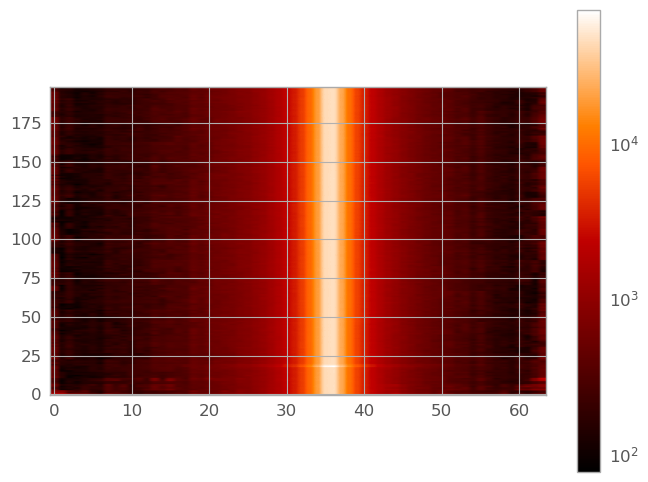

In [9]:
inargs = {'table': pn_burst, 
          'withfilteredset': 'yes', 
          'expression': "'(PATTERN <= 4)&&(PI in [200:15000])&&#XMMEA_EP'", 
          'filteredset': basic_filter_file, 
          'filtertype': 'expression', 
          'keepfilteroutput': 'yes', 
          'updateexposure': 'yes', 
          'filterexposure': 'yes'}

w('evselect', inargs).run()
inargs = {}

make_fits_image(basic_filter_file, image_file=basic_filter_image)

### 8.4 : Create and Display a Light Curve

Sometimes, it is necessary to use filters on time in addition to those mentioned above. This is because of soft proton background flaring, which can have count rates of 100 counts/sec or higher across the entire bandpass.

To determine if our observation is affected by background flaring, we can examine the light curve. For the time binning, we will set it to something reasonable (usually between 10 and 100 s).

Executing: 
evselect table='pn_basic_filter.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset=

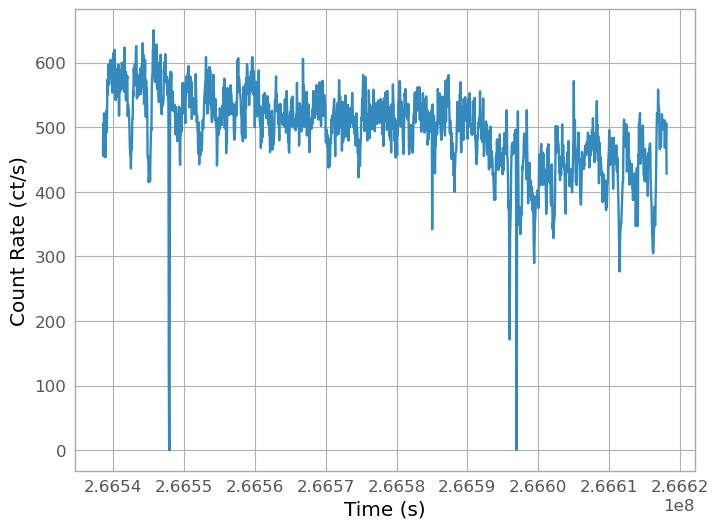

In [10]:
plot_light_curve(basic_filter_file, light_curve_file=basic_filter_ltcrv)

In this case no flares are evident, so we will continue to the next section. However, if a dataset does contain flares, they should be removed in the same way as shown for EPIC Imaging mode data in §6.5.

### 8.5 : Extract the Source and Background Spectra

The first step in extracting a spectrum from PN Timing data is to make an image of the event file over the energy range we are interested in; for this example, we'll say 0.5-15 keV. And since this is the PN, we need to remember to set `(FLAG==0)` to get a high-quality spectrum. Thus, our expression parameter would be set to `(FLAG==0) && (PI in [500:15000])`, and we make a new image using this expression.

Executing: 
evselect table='pn_basic_filter.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(FLAG==0) && (PI in [500:15000])' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='final_filter_image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='binSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='

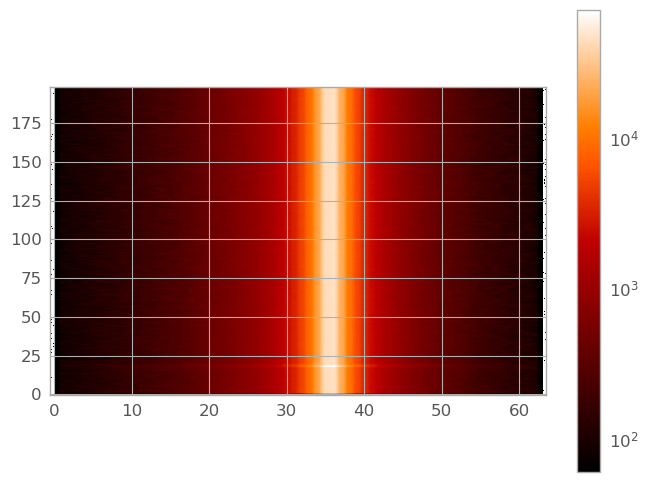

In [11]:
make_fits_image(basic_filter_file, image_file=final_filter_image, 
                expression="'(FLAG==0) && (PI in [500:15000])'")

The source is centered on `RAWX=37`; we will extract this and the 10 pixels on either side of it:

In [12]:
expression = "'(FLAG==0) && (PI in [500:15000]) && (RAWX in [27:47])'"

In [13]:
inargs = {}
inargs['table']           = basic_filter_file
inargs['spectrumset']     = source_pi_file
inargs['energycolumn']    = 'PI'
inargs['spectralbinsize'] = '5'
inargs['specchannelmin']  = '0'
inargs['specchannelmax']  = '20479'
inargs['withfilteredset'] = 'yes'
inargs['filteredset']     = pn_spectra_file
inargs['expression']      = expression

w('evselect', inargs).run()

Executing: 
evselect table='pn_basic_filter.fits' keepfilteroutput='yes' withfilteredset='yes' filteredset='pn_filt_source_WithBore.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(FLAG==0) && (PI in [500:15000]) && (RAWX in [27:47])' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PI' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='yes' spectrumset='source_pi_WithBore.fits' spectralbinsize='5' withspecranges='yes

For the background, the extraction area should be as far from the source as possible. However, sources with > 200 ct/s (like our example!) are so bright that they dominate the entire CCD area, and there is no source-free region from which to extract a background. (It goes without saying that this is highly energy-dependent.) In such a case, it may be best not to subtract a background. Users are referred to Ng et al. (2010, A&A, 522, 96) for an in-depth discussion. While this observation is too bright to have a good background extraction region, the process is shown below nonetheless for the sake of demonstration:

In [14]:
expression = "'(FLAG==0) && (PI in [500:15000]) && (RAWX in [3:5])'"

In [15]:
inargs = {}
inargs['table']           = basic_filter_file
inargs['withspectrumset'] = 'yes'
inargs['spectrumset']     = bkg_pi_file
inargs['energycolumn']    = 'PI'
inargs['spectralbinsize'] = '5'
inargs['withspecranges']  = 'yes'
inargs['specchannelmin']  = '0'
inargs['specchannelmax']  = '20479'
inargs['withfilteredset'] = 'yes'
inargs['filteredset']     = pn_bkg_file
inargs['expression']      = expression

w('evselect', inargs).run()

Executing: 
evselect table='pn_basic_filter.fits' keepfilteroutput='yes' withfilteredset='yes' filteredset='pn_filt_bkg.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(FLAG==0) && (PI in [500:15000]) && (RAWX in [3:5])' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PI' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='yes' spectrumset='bkg_pi.fits' spectralbinsize='5' withspecranges='yes' specchannelmin='0' specc

### 8.6 : Check for Pile Up

Depending on how bright the source is and what modes the EPIC detectors are in, event pile up may be a problem. Pile up occurs when a source is so bright that incoming X-rays strike two neighboring pixels or the same pixel in the CCD more than once in a read-out cycle. In such cases the energies of the two events are in effect added together to form one event. If this happens sufficiently often, 

    1. The spectrum will appear to be harder than it actually is, and 
    2. The count rate will be underestimated, since multiple events will be undercounted. 

Briefly, we deal with it in PN Timing data essentially the same way as in Imaging data, that is, by using only single pixel events, and/or removing the regions with very high count rates, checking the amount of pile up, and repeating until it is no longer a problem. We recommend to always check for it.

Note that this procedure requires as input the event files created when the spectrum was made (i.e. `pn_spectra_file = 'pn_filt_source_WithBore.fits'`), not the usual time-filtered event file.

In [16]:
inargs = ['set={0}'.format(pn_spectra_file),
          'plotfile=pn_epat.ps',
          'useplotfile=yes',
          'withbackgroundset=yes',
          'backgroundset={0}'.format(pn_bkg_file)]

w('epatplot', inargs).run()

Executing: 
epatplot set='pn_filt_source_WithBore.fits' modifyinset='yes' sigma='3' withflag='yes' xaxisadu='no' device='/VCPS' outdir='./' useplotfile='yes' plotfile='pn_epat.ps' withqdp='no' withdetxy='no' withsrcxy='yes' withoutputmask='no' outmaskname='flag0_map_##.dat' withbackgroundset='yes' backgroundset='pn_filt_bkg.fits' backscal='1.0' withusermode='no' usermode='0' withuserrawy='no' userrawy='190' ccdlimits='1 64 1 200 1 12' plotxrange='0.0 0.0' plotyrange='0.0 0.0' pileupnumberenergyrange='500 2000' 
epatplot:- Executing (routine): epatplot set=pn_filt_source_WithBore.fits modifyinset=yes sigma=3 withflag=yes xaxisadu=no device=/VCPS outdir=./ plotfile=pn_epat.ps useplotfile=yes withqdp=no withdetxy=no withsrcxy=yes outmaskname=flag0_map_##.dat withoutputmask=no backgroundset=pn_filt_bkg.fits withbackgroundset=yes backscal=1 usermode=0 withusermode=no userrawy=190 withuserrawy=no ccdlimits='1 64 1 200 1 12' plotxrange='0 0' plotyrange='0 0' pileupnumberenergyrange='500 2000'

In [17]:
gv_out = subprocess.run(['gv','pn_epat.ps'],stdout = subprocess.DEVNULL)
# Note: You will need to close the window that opens to run the remaining cells in this notebook.

The output of epatplot is a postscript file, `pn_epat.ps`, which may be viewed with viewers such as `gv`, containing two graphs describing the distribution of counts as a function of PI channel; see figure below.

<center><img src="pile_up_Cen_X-3.png"/></center>

A few words about interpretting the plots are in order. The top is the distribution of counts versus PI channel for each pattern class (single, double, triple, quadruple), and the bottom is the expected pattern distribution (smooth lines) plotted over the observed distribution (line with noise). The lower plot shows the model distributions for single and double events and the observed distributions. It also gives the ratio of observed-to-modeled events with $1-\sigma$ uncertainties for single and double pattern events over a given energy range. (The default is 0.5-2.0 keV; this can be changed with the `pileupnumberenergyrange` parameter.) If the data is not piled up, there will be good agreement between the modeled and observed single and double event pattern distributions. Also, the observed-to-modeled fractions for both singles and doubles in the 0.5-2.0 keV range will be unity, within errors. In contrast, if the data is piled up, there will be clear divergence between the modeled and observed pattern distributions, and the observed-to-modeled fraction for singles will be less than 1.0, and for doubles, it will be greater than 1.0.

Finally, when examining the plots, it should noted that the observed-to-modeled fractions can be inaccurate. Therefore, the agreement between the modeled and observed single and double event pattern distributions should be the main factor in determining if an observation is affected by pile up or not.

Examining the plots, we see that there is a large difference between the modeled and observed single and double pattern events at $> 1.0$ keV, but this divergence is not reflected in the observed-to-model fractions since for singles it is $> 1.0$ with $1.011\pm 0.001$, and for doubles it is $<1.0$ with $0.977\pm 0.001$.

To capture the pile up we need to extend the energy range for the observed-to-model fraction calculations. The default is $500-2000$ eV. Let us set the range to $1000-5000$ eV.

In [18]:
inargs = ['set={0}'.format(pn_spectra_file),
          'plotfile=pn_epat.ps',
          'useplotfile=yes',
          'pileupnumberenergyrange=1000 5000',
          'withbackgroundset=yes',
          'backgroundset={0}'.format(pn_bkg_file)]

w('epatplot', inargs).run()

Executing: 
epatplot set='pn_filt_source_WithBore.fits' modifyinset='yes' sigma='3' withflag='yes' xaxisadu='no' device='/VCPS' outdir='./' useplotfile='yes' plotfile='pn_epat.ps' withqdp='no' withdetxy='no' withsrcxy='yes' withoutputmask='no' outmaskname='flag0_map_##.dat' withbackgroundset='yes' backgroundset='pn_filt_bkg.fits' backscal='1.0' withusermode='no' usermode='0' withuserrawy='no' userrawy='190' ccdlimits='1 64 1 200 1 12' plotxrange='0.0 0.0' plotyrange='0.0 0.0' pileupnumberenergyrange='1000 5000' 
epatplot:- Executing (routine): epatplot set=pn_filt_source_WithBore.fits modifyinset=yes sigma=3 withflag=yes xaxisadu=no device=/VCPS outdir=./ plotfile=pn_epat.ps useplotfile=yes withqdp=no withdetxy=no withsrcxy=yes outmaskname=flag0_map_##.dat withoutputmask=no backgroundset=pn_filt_bkg.fits withbackgroundset=yes backscal=1 usermode=0 withusermode=no userrawy=190 withuserrawy=no ccdlimits='1 64 1 200 1 12' plotxrange='0 0' plotyrange='0 0' pileupnumberenergyrange='1000 500

In [19]:
gv_out = subprocess.run(['gv','pn_epat.ps'],stdout = subprocess.DEVNULL)
# Note: You will need to close the window that opens to run the remaining cells in this notebook.

Now the cacluated observed-to-model fractions are $0.988\pm 0.001$ for singles, and $1.121\pm 0.001$ for doubles. This shows clear evidence of pile up.

### 8.7 : My Observation is Piled Up! Now What?

There are a couple ways to deal with pile up. First, you can use event file filtering procedures to include only single pixel events `(PATTERN==0)`, as these events are less sensitive to pile up than other patterns.

You can also excise areas of high count rates, i.e., the boresight column and several columns to either side of it. (This is analogous to removing the inner-most regions of a source in Imaging data.) The spectrum can then be re-extracted and you can continue your analysis on the excised event file. As with Imaging data, it is recommended that you take an iterative approach: remove an inner region, extract a spectrum, check with epatplot, and repeat, each time removing a slightly larger region, until the model and observed pattern distributions agree.

To extract only the columns to either side of the boresight using the following expression when running `evselect`. All other inputs are the same as in §8.5.

<div class="alert alert-block alert-info">
    <b>Note:</b> We will not do the additional filtering for pile up here. We will just show the expression and inputs below. If you are only concerned with lower energies in the range of 500-2000 eV then pile up does not significantly affect this observation. But if you are interested in higher energies > 2000 eV, then you will need to correct for pile up. We recommend checking for pile up in the energy range you are interested in by using the <i>pileupnumberenergyrange</i> input for <i>epatplot</i>.
</div>

```python
expression = "'(FLAG==0)&&(PI in [500:15000])&&(RAWX in [3:5])&&!(RAWX in [29:45])'"

inargs = {}
inargs['table']           = basic_filter_file
inargs['withspectrumset'] = 'yes'
inargs['spectrumset']     = source_pi_file
inargs['energycolumn']    = 'PI'
inargs['spectralbinsize'] = '5'
inargs['withspecranges']  = 'yes'
inargs['specchannelmin']  = '0'
inargs['specchannelmax']  = '20479'
inargs['withfilteredset'] = 'yes'
inargs['filteredset']     = pn_spectra_file
inargs['expression']      = expression

w('evselect', inargs).run()
```

### 8.8 : Determine the Spectrum Extraction Areas

Now that we are confident that our spectrum is not piled up, we can continue by finding the source and background region areas. (This process is identical to that used for IMAGING data.) This is done with the task backscale, which takes into account any bad pixels or chip gaps, and writes the result into the BACKSCAL keyword of the spectrum table.

The inputs are:

    -spectrumset - (input) spectrum file
    -badpixlocation - (output) event file containing the bad pixels

In [21]:
inargs = ['spectrumset={0}'.format(source_pi_file),
          'badpixlocation=pn_filt.fits']

w('backscale', inargs).run()

Executing: 
backscale spectrumset='source_pi_WithBore.fits' badpixlocation='pn_filt.fits' withbadpixcorr='yes' useodfatt='no' ignoreoutoffov='yes' withbadpixres='no' badpixelresolution='2' 
backscale:- Executing (routine): backscale spectrumset=source_pi_WithBore.fits badpixlocation=pn_filt.fits withbadpixcorr=yes useodfatt=no ignoreoutoffov=yes badpixelresolution=2 withbadpixres=no  -w 1 -V 4
backscale:- backscale (backscale-1.6)  [xmmsas_20230412_1735-21.0.0] started:  2024-06-11T18:01:48.000
backscale:- Executing (routine): arfgen spectrumset=source_pi_WithBore.fits rmfset=response.ds withrmfset=no arfset=deletearf.ds detmaptype=flat detmaparray=detmapfile.ds: detxoffset=1200 detyoffset=1200 withdetbounds=no detxbins=1 detybins=1 withdetbins=yes psfenergy=2 filterdss=yes filteredset=filteredpixellist.ds withfilteredset=no sourcecoords=eqpos sourcex=0 sourcey=0 withsourcepos=no extendedsource=no modeleffarea=no modelquantumeff=no modelfiltertrans=no modelcontamination=yes modelee=no 

In [22]:
inargs = ['spectrumset={0}'.format(bkg_pi_file),
          'badpixlocation=pn_filt.fits']

w('backscale', inargs).run()

Executing: 
backscale spectrumset='bkg_pi.fits' badpixlocation='pn_filt.fits' withbadpixcorr='yes' useodfatt='no' ignoreoutoffov='yes' withbadpixres='no' badpixelresolution='2' 
backscale:- Executing (routine): backscale spectrumset=bkg_pi.fits badpixlocation=pn_filt.fits withbadpixcorr=yes useodfatt=no ignoreoutoffov=yes badpixelresolution=2 withbadpixres=no  -w 1 -V 4
backscale:- backscale (backscale-1.6)  [xmmsas_20230412_1735-21.0.0] started:  2024-06-11T18:03:21.000
backscale:- Executing (routine): arfgen spectrumset=bkg_pi.fits rmfset=response.ds withrmfset=no arfset=deletearf.ds detmaptype=flat detmaparray=detmapfile.ds: detxoffset=1200 detyoffset=1200 withdetbounds=no detxbins=1 detybins=1 withdetbins=yes psfenergy=2 filterdss=yes filteredset=filteredpixellist.ds withfilteredset=no sourcecoords=eqpos sourcex=0 sourcey=0 withsourcepos=no extendedsource=no modeleffarea=no modelquantumeff=no modelfiltertrans=no modelcontamination=yes modelee=no modelootcorr=yes applyxcaladjustment

### 8.9 : Create the Photon Redistribution Matrix (RMF) and Ancillary File (ARF)

Making the RMF and ARF for PN data in `TIMING` mode is exactly the same as in `IMAGING` mode, even if you had to excise piled up areas.

To make the RMF use `rmfgen`. The inputs are:

    -rmfset - output file
    -spectrumset - spectrum file

rmfgen rmfset=source_rmf_NoBore.fits spectrumset=source_pi_NoBore.fits

To make the ARF use `arfgen`. The inputs are:

    -arfset - output file
    -spectrumset - spectrum file
    -arfset - output file
    -detmaptype - origin of the detector map
    -withrmfset - use the RMF dataset to define the ARF energy grid?
    -rmfset - RMF file
    -badpixlocation - the file containing the bad pixel locations

In [23]:
inargs = ['rmfset=source_rmf_NoBore.fits',
          'spectrumset={0}'.format(source_pi_file)]

w('rmfgen', inargs).run()

Executing: 
rmfgen rmfset='source_rmf_NoBore.fits' threshold='1e-06' withenergybins='no' energymin='0' energymax='15' nenergybins='30' spectrumset='source_pi_WithBore.fits' format='var' detmaptype='psf' detmaparray='detmapfile.ds:' withdetbounds='no' detxoffset='1200' detyoffset='1200' withdetbins='yes' detxbins='160' detybins='160' correctforpileup='no' raweventfile='rawevents.ds' filterdss='yes' withfilteredset='no' filteredset='filteredpixellist.ds' withrmfset='no' psfenergy='2' withsourcepos='no' sourcecoords='eqpos' sourcex='0' sourcey='0' extendedsource='no' modeleffarea='no' modelquantumeff='no' modelfiltertrans='no' modelcontamination='no' modelee='yes' modelootcorr='no' eegridfactor='100' withbadpixcorr='no' badpixlocation='notSpecified' setbackscale='no' keeparfset='yes' useodfatt='no' ignoreoutoffov='yes' crossregionarf='no' crossreg_spectrumset='' psfmodel='notSpecified' withbadpixres='no' badpixelresolution='2' applyxcaladjustment='no' acceptchanrange='no' applyabsfluxcorr

In [24]:
inargs = ['arfset=source_arf_NoBore.fits',
          'spectrumset={0}'.format(source_pi_file),
          'detmaptype=psf',
          'withrmfset=yes',
          'rmfset=source_rmf_NoBore.fits',
          'badpixlocation=pn_filt.fits']

w('arfgen', inargs).run()

Executing: 
arfgen spectrumset='source_pi_WithBore.fits' withrmfset='yes' rmfset='source_rmf_NoBore.fits' arfset='source_arf_NoBore.fits' detmaptype='psf' detmaparray='detmapfile.ds:' withdetbounds='no' detxoffset='1200' detyoffset='1200' withdetbins='no' detxbins='5' detybins='5' psfenergy='2' filterdss='yes' withfilteredset='no' filteredset='filteredpixellist.ds' withsourcepos='no' sourcecoords='eqpos' sourcex='0' sourcey='0' extendedsource='no' modeleffarea='yes' modelquantumeff='yes' modelfiltertrans='yes' modelcontamination='yes' modelee='yes' modelootcorr='yes' applyxcaladjustment='no' applyabsfluxcorr='no' eegridfactor='100' withbadpixcorr='yes' badpixlocation='pn_filt.fits' psfmodel='ELLBETA' withbadpixres='no' badpixelresolution='2' badpixmaptype='flat' setbackscale='no' keeparfset='yes' useodfatt='no' ignoreoutoffov='yes' crossregionarf='no' crossreg_spectrumset='' 
arfgen:- Executing (routine): arfgen spectrumset=source_pi_WithBore.fits rmfset=source_rmf_NoBore.fits withrmfs

At this point, the spectrum is ready to be analyzed. How to fit the spectrum is explained in [Chapter 13 of the ABC Guide](https://heasarc.gsfc.nasa.gov/docs/xmm/abc/node15.html#Chap:epic-fit-xspec).